# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2022spring-ta@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [ ]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu 


Next, set up virtual display，and import all necessaary packages.

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np

from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [ ]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [ ]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [ ]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

0


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
observation, reward, done, info = env.step(random_action)

In [ ]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [ ]:
print(reward)

-0.8588900517154912


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

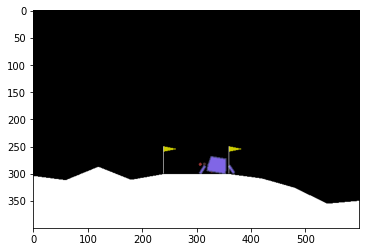

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Hyper Parameters

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256  # 128   # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4             # learning rate 
UPDATE_EVERY = 4  # 4   # how often to update the network

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
# class PolicyGradientNetwork(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(8, 16)
#         self.fc2 = nn.Linear(16, 16)
#         self.fc3 = nn.Linear(16, 4)

#     def forward(self, state):
#         hid = torch.tanh(self.fc1(state))
#         hid = torch.tanh(self.fc2(hid))
#         return F.softmax(self.fc3(hid), dim=-1)

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities. 

In [ ]:
class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = DQN(state_size, action_size).to(device)
        self.qnetwork_target = DQN(state_size, action_size).to(device)
        # optimizer
        # self.optimizer = optim.RMSprop(self.qnetwork_local.parameters(), lr=1e-4)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
# from torch.optim.lr_scheduler import StepLR
# class PolicyGradientAgent():
    
#     def __init__(self, network):
#         self.network = network
#         self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
        
#     def forward(self, state):
#         return self.network(state)

#     def learn(self, log_probs, rewards):
#         loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
        
#     def sample(self, state):
#         action_prob = self.network(torch.FloatTensor(state))
#         action_dist = Categorical(action_prob)
#         action = action_dist.sample()
#         log_prob = action_dist.log_prob(action)
#         return action.item(), log_prob

Lastly, build a network and agent to start training.

In [ ]:
# network = PolicyGradientNetwork()
# agent = PolicyGradientAgent(network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [ ]:
def training(n_episodes=3000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 270:  # 270
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [ ]:
agent = DQNAgent(state_size=8, action_size=4)
scores = training()

Episode 100	Average Score: -162.95
Episode 200	Average Score: -106.48
Episode 300	Average Score: -26.63
Episode 400	Average Score: 46.97
Episode 500	Average Score: 145.34
Episode 600	Average Score: 178.43
Episode 700	Average Score: 189.28
Episode 800	Average Score: 167.68
Episode 900	Average Score: 196.67
Episode 1000	Average Score: 213.71
Episode 1100	Average Score: 233.66
Episode 1200	Average Score: 230.15
Episode 1300	Average Score: 237.92
Episode 1400	Average Score: 235.18
Episode 1500	Average Score: 240.80
Episode 1600	Average Score: 236.68
Episode 1700	Average Score: 250.18
Episode 1800	Average Score: 239.49
Episode 1900	Average Score: 256.29
Episode 2000	Average Score: 241.09
Episode 2100	Average Score: 242.21
Episode 2200	Average Score: 251.16
Episode 2300	Average Score: 244.95
Episode 2400	Average Score: 248.90
Episode 2500	Average Score: 237.40
Episode 2600	Average Score: 239.00
Episode 2700	Average Score: 246.11
Episode 2800	Average Score: 258.58
Episode 2900	Average Score: 

In [ ]:
# agent.network.train()  # Switch network into training mode 
# EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
# NUM_BATCH = 500        # totally update the agent for 400 time

# avg_total_rewards, avg_final_rewards = [], []

# prg_bar = tqdm(range(NUM_BATCH))
# for batch in prg_bar:

#     log_probs, rewards = [], []
#     total_rewards, final_rewards = [], []

#     # collect trajectory
#     for episode in range(EPISODE_PER_BATCH):
        
#         state = env.reset()
#         total_reward, total_step = 0, 0
#         seq_rewards = []
#         while True:

#             action, log_prob = agent.sample(state) # at, log(at|st)
#             next_state, reward, done, _ = env.step(action)

#             log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
#             # seq_rewards.append(reward)
#             state = next_state
#             total_reward += reward
#             total_step += 1
#             rewards.append(reward) # change here
#             # ! IMPORTANT !
#             # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
#             #                                                         rewards :     r1, r2 ,r3 ......
#             # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
#             #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
#             # boss : implement Actor-Critic
#             if done:
#                 final_rewards.append(reward)
#                 total_rewards.append(total_reward)
                
#                 break

#     # print(f"rewards looks like ", np.shape(rewards))  
#     # print(f"log_probs looks like ", np.shape(log_probs))     
#     # record training process
#     avg_total_reward = sum(total_rewards) / len(total_rewards)
#     avg_final_reward = sum(final_rewards) / len(final_rewards)
#     avg_total_rewards.append(avg_total_reward)
#     avg_final_rewards.append(avg_final_reward)
#     prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

#     # update agent
#     # rewards = np.concatenate(rewards, axis=0)
#     rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward 
#     agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
#     print("logs prob looks like ", torch.stack(log_probs).size())
#     print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


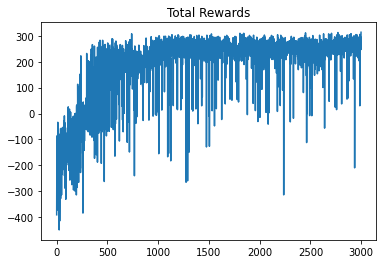

In [ ]:
plt.plot(scores)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


In [ ]:
# plt.plot(avg_final_rewards)
# plt.title("Final Rewards")
# plt.show()

## Testing
The testing result will be the average reward of 5 testing

In [ ]:
fix(env, seed)
agent.qnetwork_local.eval()
agent.qnetwork_target.eval()
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []

for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  while not done:

      action = agent.act(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      # img.set_data(env.render(mode='rgb_array'))
      # display.display(plt.gcf())
      # display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 


/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

NameError: ignored

Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

Saving the result of Model Testing


In [ ]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list)) 

### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
from google.colab import files
files.download(PATH)

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

In [ ]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

# set network to evaluation mode
agent.qnetwork_local.eval()
agent.qnetwork_target.eval()

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
